In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from colour import Color
import seaborn as sn
import pandas as pd
from statistics import mean, stdev
import pingouin as pg
from scipy import stats
import random
import math
import statsmodels.api as sm 
from statsmodels.formula.api import ols

def outputIconForStats(pval):
    if pval <= 0.05:
        icon = '*'
    else:
        icon = ' '
    return icon

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}    
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)
        
    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(d_cond):
    #compare against chance
    r_data = np.random.choice([0, 1], size=len(d_cond), p=[.5, .5])
    result = pg.ttest(d_cond, r_data, correction=True) 
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True) 

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof
    
def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    
    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable] 
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):    
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")

        
def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):    
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))

# !pip install colour

def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)
        
    print("bootstraptime",BootstrapTimes,"sampletime",SampleTimes)
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))
    
    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

def ConcatData(data1, data2):
    import random
    import math
    
    #print(data1)
    #print(data2)
    if len(data1) < len(data2):        
        BootstrapTimes = len(data1)
    else:        
        BootstrapTimes = len(data2)
    
    #print(BootstrapTimes)
    y1 = random.sample(data1, BootstrapTimes)
    #print(y1)
    y2 = random.sample(data2, BootstrapTimes)
    #print(y2)
    y_comb = y1+y2
    y_comb = np.array(y_comb)        
    return y_comb


def ComputeBarStdConfMat(contents):
    modelist = ['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    print(modelist)
    
    #initialize matrix of absolute counts   
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    #print(result)

    # Iterating over keys
    for trialid in contents:
        trialinfor = contents[trialid]['trialData']

        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)
                
        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)
                
            modelname = trialinfor['machine_groundtruth']
            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)
                
    #print(result)

    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']  
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    stdmodelist = ['M', 'git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    modelist_stats = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    top1 = []
    top1_std = []
    resultFlist = {}
    #print(result_conf_mat)
    #data1tot = np.array(result['result_H'])
    data1tot = result['result_H']
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        # compute bootstrap accuracy
        # compute and save std for top1 accuracy
        top_std_AI = boostrap(result['result_H'], result['result_' + stdmodelist[i]])
        top1_std.append(top_std_AI)
        data2tot = result['result_' + stdmodelist[i]]
        #resultFlist[modelist_stats[i]] = np.concatenate((data1tot,data2tot))
        resultFlist[modelist_stats[i]] = ConcatData(data1tot,data2tot)
        
    #print(top1)
    
    return top1, top1_std, result_conf_mat, resultFlist



with open("./savedResults/compiled.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'combined' #choose from these choices: inlab, mturk
folderpath = './plots/Task1_' + key + '_' #for saving the plots
human_trials = CompiledResults[key]

condition_list = ['ageL35','ageG35L45','ageG45','F','M','school','bachelor','postgrad',
                  'in-domain','near-domain','out-domain']
#,'live','sandbox']

condition_list_criteria = {'ageL35': ["18-20","21-25","26-30","31-35"], 'ageG35L45': ["36-40","41-45"], 
                           'ageG45': ["45-50","46-50"],
                           'F': ['female'],'M': ['male'], 'school': ["middle school","high school"],
                           'bachelor':['bachelor'],'postgrad': ['master','pg'],
                          'in-domain':['in-domain'],'near-domain':['near-domain'],'out-domain':['out-domain']}
condition_attribute = {'ageL35':'age','ageG35L45':'age','ageG45':'age',
                       'F' :'gender','M':'gender',
                       'school':'education','bachelor':'education','postgrad':'education',
                      'in-domain':'imagetype', 'near-domain':'imagetype','out-domain':'imagetype'}


condition_numSubjs = {'ageL35':0,'ageG35L45':0,'ageG45':0,
                       'F' :0,'M':0,
                       'school':0,'bachelor':0,'postgrad':0,
                     'in-domain':0,'near-domain':0,'out-domain':0}
condition_results = {'ageL35':{},'ageG35L45':{},'ageG45':{},
                       'F' :{},'M':{},
                       'school':{},'bachelor':{},'postgrad':{},
                    'in-domain':{},'near-domain':{},'out-domain':{}}

for condition_chosen in condition_list:
    for trial, dat in human_trials.items():
        if dat['workerData'][condition_attribute[condition_chosen]] in condition_list_criteria[condition_chosen]:
#             print(condition_chosen)
#             print(condition_numSubjs)
            condition_numSubjs[condition_chosen] = condition_numSubjs[condition_chosen] + 1
#             print(condition_numSubjs[condition_chosen])
            condition_results[condition_chosen]['Trial_'+str(condition_numSubjs[condition_chosen])] = dat

print(condition_numSubjs)


C:\Users\a0091\.conda\envs\py39\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


{'ageL35': 3740, 'ageG35L45': 3040, 'ageG45': 2620, 'F': 4540, 'M': 4740, 'school': 3240, 'bachelor': 4980, 'postgrad': 1180, 'in-domain': 2480, 'near-domain': 2180, 'out-domain': 2660}


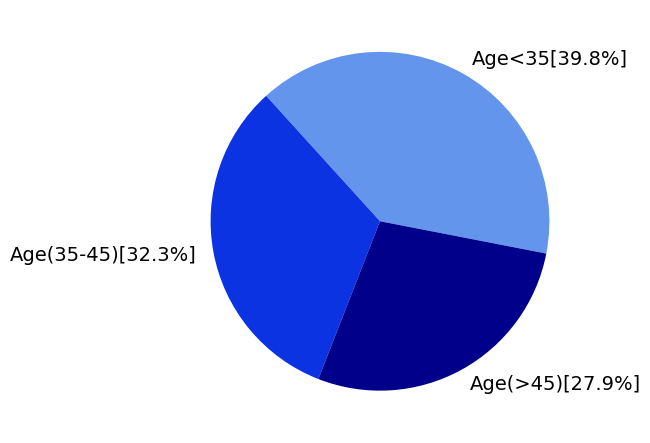

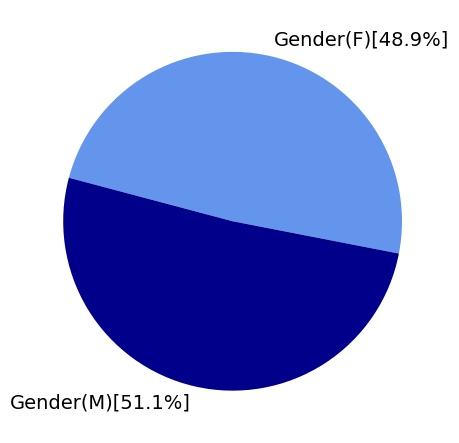

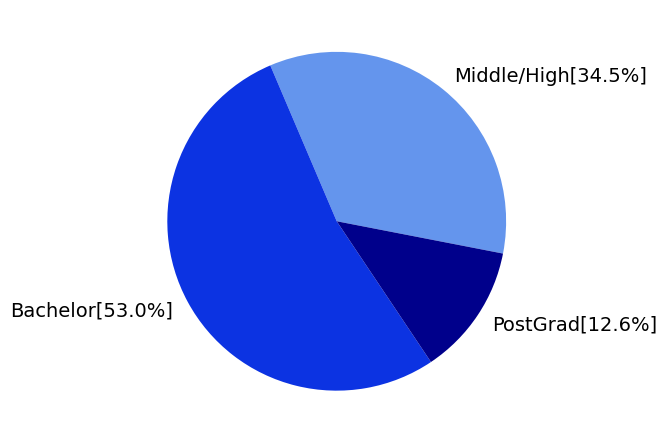

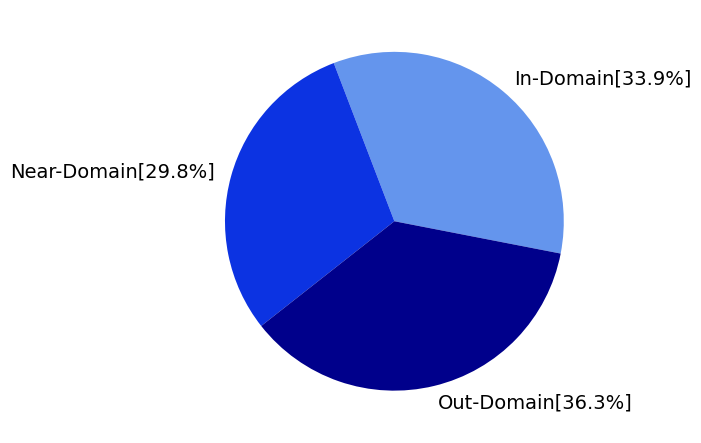

In [2]:
startColor = Color('#6495ED') #light blue
EndColor = Color("#00008B") #dark blue

#data: a list containing counts of each bin
#labels: for each data bin
#startcolor: fixed; do NOT change, always start from light blue
#endcolor: fixed; do NOT change, always end with dark blue
def plot_PieCharts(data, labels, startcolor, endcolor, folderpath, demoinfor):
    
    #label must have same lengths as data
    #normalize the list of data so that sum is 1
    datanorm = [float(i)/sum(data) for i in data]
    labels_actual = []
    for i, item in enumerate(datanorm):
        labels_actual.append( labels[i]+ "[" + str("{:.1f}".format(item*100)) + "%]" )
    
    colors = list(startColor.range_to(EndColor,len(datanorm)))
    colorlist = []
    for item in colors:
        colorlist.append(item.hex)
    #print(colorlist)
    plt.figure(figsize=(8, 5.5))
    plt.pie(datanorm, labels = labels_actual, colors = colorlist, startangle = -11, textprops={'fontsize': 14})
    plt.savefig(folderpath + demoinfor + '_DemorDistri.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + demoinfor + '_DemorDistri.png', bbox_inches='tight')
    plt.show() 


agelist = np.array([condition_numSubjs['ageL35'],
                    condition_numSubjs['ageG35L45'],
                    condition_numSubjs['ageG45']]) #number of counts within a bin
mylabels = ["Age<35","Age(35-45)","Age(>45)"]
demoinfor = 'age'
plot_PieCharts(agelist, mylabels, startColor, EndColor, folderpath, demoinfor)
    
agelist = np.array([condition_numSubjs['F'],condition_numSubjs['M']]) #number of counts within a bin
mylabels = ["Gender(F)",'Gender(M)']
demoinfor = 'gender'
plot_PieCharts(agelist, mylabels, startColor, EndColor, folderpath, demoinfor)
    
agelist = np.array([condition_numSubjs['school'],
                    condition_numSubjs['bachelor'], 
                    condition_numSubjs['postgrad']]) #number of counts within a bin
demoinfor = 'education'
mylabels = ["Middle/High","Bachelor","PostGrad"]
plot_PieCharts(agelist, mylabels, startColor, EndColor, folderpath, demoinfor)

agelist = np.array([condition_numSubjs['in-domain'],
                    condition_numSubjs['near-domain'], 
                    condition_numSubjs['out-domain']]) #number of counts within a bin
demoinfor = 'imagetype'
mylabels = ["In-Domain","Near-Domain","Out-Domain"]
plot_PieCharts(agelist, mylabels, startColor, EndColor, folderpath, demoinfor)


['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 1870 sampletime 935
bootstraptime 374 sampletime 187
bootstraptime 374 sampletime 187
bootstraptime 374 sampletime 187
bootstraptime 374 sampletime 187
bootstraptime 374 sampletime 187
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 1520 sampletime 760
bootstraptime 304 sampletime 152
bootstraptime 304 sampletime 152
bootstraptime 304 sampletime 152
bootstraptime 304 sampletime 152
bootstraptime 304 sampletime 152
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 1310 sampletime 655
bootstraptime 262 sampletime 131
bootstraptime 262 sampletime 131
bootstraptime 262 sampletime 131
bootstraptime 262 sampletime 131
bootstraptime 262 sampletime 131
Machine ageL35
Machine ageG35L45
Machine ageG45
GIT ageL35
GIT ageG35L45
GIT ageG45
OFA ageL35
OFA ageG35L45
OFA ageG45
BLIP ageL35
BLIP ageG35L45
BLIP ageG45
ClipCap ageL35
ClipCap ageG35L45
ClipCap ageG45
Microsoft_API ageL35
Microsoft_API ageG35L4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


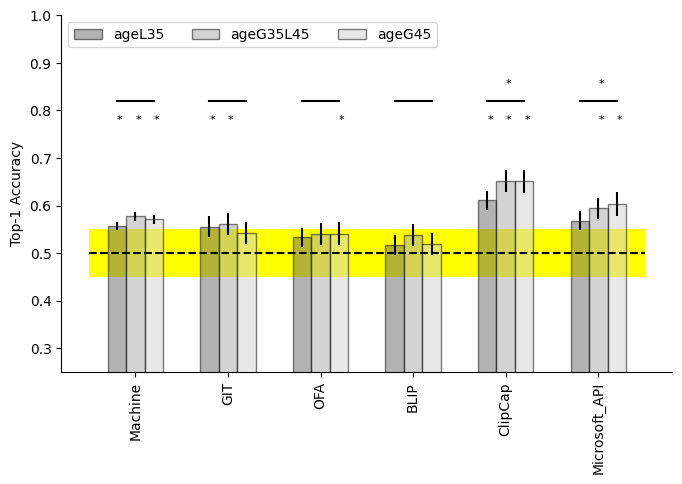

['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 2270 sampletime 1135
bootstraptime 454 sampletime 227
bootstraptime 454 sampletime 227
bootstraptime 454 sampletime 227
bootstraptime 454 sampletime 227
bootstraptime 454 sampletime 227
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 2370 sampletime 1185
bootstraptime 474 sampletime 237
bootstraptime 474 sampletime 237
bootstraptime 474 sampletime 237
bootstraptime 474 sampletime 237
bootstraptime 474 sampletime 237
Machine F
Machine M
GIT F
GIT M
OFA F
OFA M
BLIP F
BLIP M
0.5042194092827004
ClipCap F
ClipCap M
Microsoft_API F
Microsoft_API M


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


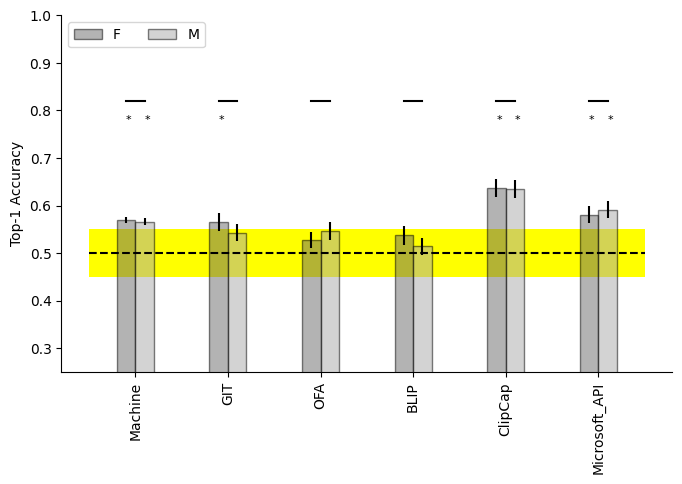

['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 1620 sampletime 810
bootstraptime 324 sampletime 162
bootstraptime 324 sampletime 162
bootstraptime 324 sampletime 162
bootstraptime 324 sampletime 162
bootstraptime 324 sampletime 162
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 2490 sampletime 1245
bootstraptime 498 sampletime 249
bootstraptime 498 sampletime 249
bootstraptime 498 sampletime 249
bootstraptime 498 sampletime 249
bootstraptime 498 sampletime 249
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 590 sampletime 295
bootstraptime 118 sampletime 59
bootstraptime 118 sampletime 59
bootstraptime 118 sampletime 59
bootstraptime 118 sampletime 59
bootstraptime 118 sampletime 59
Machine school
Machine bachelor
Machine postgrad
GIT school
GIT bachelor
GIT postgrad
OFA school
OFA bachelor
OFA postgrad
BLIP school
BLIP bachelor
BLIP postgrad
ClipCap school
ClipCap bachelor
ClipCap postgrad
Microsoft_API school
Microsoft_API bachelor

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


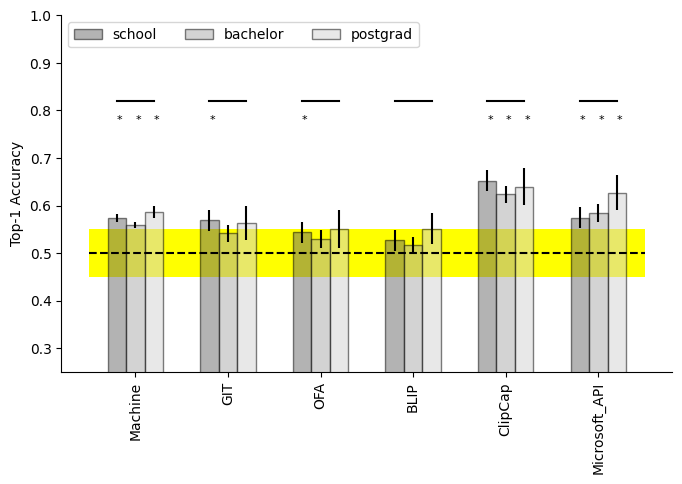

['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 1240 sampletime 620
bootstraptime 248 sampletime 124
bootstraptime 248 sampletime 124
bootstraptime 248 sampletime 124
bootstraptime 248 sampletime 124
bootstraptime 248 sampletime 124
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 1090 sampletime 545
bootstraptime 218 sampletime 109
bootstraptime 218 sampletime 109
bootstraptime 218 sampletime 109
bootstraptime 218 sampletime 109
bootstraptime 218 sampletime 109
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 1330 sampletime 665
bootstraptime 266 sampletime 133
bootstraptime 266 sampletime 133
bootstraptime 266 sampletime 133
bootstraptime 266 sampletime 133
bootstraptime 266 sampletime 133
Machine in-domain
Machine near-domain
Machine out-domain
GIT in-domain
GIT near-domain
GIT out-domain
OFA in-domain
OFA near-domain
OFA out-domain
BLIP in-domain
BLIP near-domain
BLIP out-domain
ClipCap in-domain
ClipCap near-domain
ClipCap out-domai

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


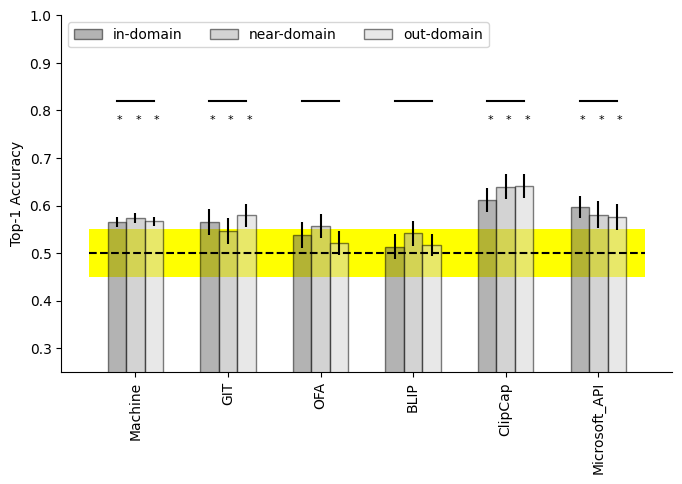

In [3]:
### plots for grouping demographic information
def plot_res_demographics(condition_chosen_list, TextFilePath, plotname,facebarcolor, condition_results):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Rectangle
    
    compiledAllConds = {}
    
    modelist = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    Pdata = {} #data stored for computing statistics 
    #initialize PData
    for i in range(0,len(modelist)):
        Pdata[modelist[i]] = {}
        
    for condition_chosen in condition_chosen_list:
                
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(condition_results[condition_chosen])
        
        for i in range(0,len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]
        
#         #compute barplot and errorbar of barplot
#         top1 = []
#         top1std = []

#         #compute confusion matrix
#         result_conf_mat = 

        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen +'_std'] = top1std
    
    ### we have the compiled resutls now; lets calculate stats
    chancePval = []
    groupPval = []
    for i in range(0,len(modelist)):
        for condition_chosen in condition_chosen_list:        
            #compute against chance 50%
            
            d_cond = Pdata[modelist[i]][condition_chosen]
            print(modelist[i], condition_chosen)
            #print(d_cond)
            if condition_chosen == 'M' and modelist[i] == 'BLIP':
                d_cond = [float(val) for val in d_cond]
                print(mean(d_cond))
            icon, pval, Tval, dof = ComputeStats_group1(d_cond)
            
#             print(condition_chosen, modelist[i])
#             displayStats_group12(pval, Tval, dof)   
            
            chancePval.append(icon)
        if len(Pdata[modelist[i]].keys()) == 2:
            data_d1 = Pdata[modelist[i]][condition_chosen_list[0]]
            data_d2 = Pdata[modelist[i]][condition_chosen_list[1]]
            icon, pval, Tval, dof =  ComputeStats_group2(data_d1, data_d2)
            groupPval.append(icon)
        elif len(Pdata[modelist[i]].keys()) >= 3: 
            icon, BetweenGP_df, WithinGP_df, Fval, pval = ComputeStats_group3(Pdata[modelist[i]])
            groupPval.append(icon)
        else:
            print("Oops!  This should NOT happen...")
    
    
    ### we have the compiled resutls now; lets plot stats
    #data
    #x-axis
    years = list(range(1, len(modelist)))
    strtask = modelist
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = [] #for plotting stats * or n.s.
    
    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5 #len(condition_chosen_list)
    else:
        multiplier = -1 #len(condition_chosen_list)
    #ngroups = len(condition_chosen_list)

    ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)    

    for ind, condition_chosen in enumerate(condition_chosen_list):
    #for condition_chosen in condition_chosen_list:
    #for attribute, measurement in compiledAllConds.items():
        measurement = compiledAllConds[condition_chosen]
        measurement_std = compiledAllConds[condition_chosen + '_std']
        attribute = condition_chosen
        
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, yerr= measurement_std, width = width,alpha=0.5,
                       label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')#,
                       #align='center', alpha=0.5, ecolor='black', capsize=10,color ='black')
        #ax.bar_label(rects, padding=3)
        point_x.extend( (x+offset).tolist() )
        multiplier += 1
    
#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    ########## ready for plotting stats
    #print(point_x)
    ###### getting statistics
    point_x.sort(reverse=False)
    #print(point_x)
    for i, p in enumerate(point_x):        
        ax.text(p, .7, chancePval[i], fontsize=8, transform=ax.get_xaxis_transform())

    ax.set_xticks(x, strtask)
    ax.legend(loc='upper left', ncols=len(condition_chosen_list))

    ###### plot stats for each group of bars
    totalPx = len(point_x)
#     print(totalPx)
#     print(point_x)
    count = 0
    for s1 in range(0,totalPx, len(condition_chosen_list)):
        center_x = 0
        for s2 in range(0,len(condition_chosen_list)):
            center_x = center_x + point_x[s1+s2]
        center_x = center_x/len(condition_chosen_list)
        starting_x = point_x[s1]
        ending_x = point_x[s1+len(condition_chosen_list)-1]
        plt.plot(   np.array([starting_x, ending_x]),
                           np.arange(2)*0+0.82, 'k', label='chance (50%)')
        ax.text(center_x, .8, groupPval[count], fontsize=8, transform=ax.get_xaxis_transform())
        count = count + 1
    
    ###### ending: plot stats for each group of bars
    
    
    plt.ylabel('Top-1 Accuracy')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.25, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5 
    chancex =np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(7)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.savefig(plotname + '.png',  bbox_inches='tight')
    plt.show()
#     fig.savefig('../' + plotname + '.png', bbox_inches='tight')
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.pdf', bbox_inches='tight')
    
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.png', bbox_inches='tight')


#======================AGE=======
#condition_list = ['ageL35','ageG35L45','ageG45','F','M','school','bachelor','postgrad','US','nonUS','wGenderQ','woGenderQ']
condition_chosen_list = ['ageL35','ageG35L45','ageG45']
TextFilePath = './savedResults/Task1_' + key + '_'
plotpathname = './plots/Task1_' + key + '_demor_AgeBarPlotOverall' #for saving the plots
facebarcolor = ['dimgray','darkgrey','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, condition_results)


#================================= Gender
#condition_list = ['ageL35','ageG35L45','ageG45','F','M','school','bachelor','postgrad','US','nonUS','wGenderQ','woGenderQ']
condition_chosen_list = ['F','M']
TextFilePath = './savedResults/Task1_' + key + '_'
plotpathname = './plots/Task1_' + key + '_demor_GenderBarPlotOverall' #for saving the plots
facebarcolor = ['dimgray','darkgrey','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, condition_results)

#================================= Education
#condition_list = ['ageL35','ageG35L45','ageG45','F','M','school','bachelor','postgrad','US','nonUS','wGenderQ','woGenderQ']
condition_chosen_list = ['school','bachelor','postgrad']
TextFilePath = './savedResults/Task1_' + key + '_'
plotpathname = './plots/Task1_' + key + '_demor_EducationBarPlotOverall' #for saving the plots
facebarcolor = ['dimgray','darkgrey','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, condition_results)

#================================= imageType
#condition_list = ['ageL35','ageG35L45','ageG45','F','M','school','bachelor','postgrad','US','nonUS','wGenderQ','woGenderQ']
condition_chosen_list = ['in-domain','near-domain','out-domain']
TextFilePath = './savedResults/Task1_' + key + '_'
plotpathname = './plots/Task1_' + key + '_demor_ImageTypeBarPlotOverall' #for saving the plots
facebarcolor = ['dimgray','darkgrey','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, condition_results)

In [4]:
random.sample([1,2,3,4],2)


[2, 4]